In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import itertools
import os

# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

np.random.seed(seed)
tf.random.set_seed(seed)

# GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters
img_height, img_width = 224, 224
batch_size = 8
num_classes = 2

# Paths to datasets
train_path = './train'
valid_path = './valid'
test_path = './test'

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,  # Increased rotation
    brightness_range=[0.6, 1.4],  # Broader brightness range
    width_shift_range=0.2,     # Larger horizontal shift
    height_shift_range=0.2,    # Larger vertical shift
    shear_range=0.2,           # Larger shear
    zoom_range=0.2,            # Larger zoom
    channel_shift_range=20,    # Increase color shift
    horizontal_flip=True,
    fill_mode='nearest')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Set seeds for data generators
train_batches = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed
)

valid_batches = datagen.flow_from_directory(
    directory=valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Ensure class_mode is set to 'binary'
    shuffle=False,
    seed=seed
)

test_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Ensure class_mode is set to 'binary'
    shuffle=False,
)

# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
print(f"Total layers in MobileNetV2: {len(base_model.layers)}")

# Add custom layers
base_model_output = GlobalAveragePooling2D()(base_model.output)
x = Dense(units=512, activation='relu')(base_model_output)
x = Dropout(0.5)(x)  # Remove seed parameter
output = Dense(units=1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

# Freezing the base model
#base_model.trainable = False  #Freeze all layers
#base_model.trainable = True   #Unfreeze all layers

# Freeze Custom Layers
for i, layer in enumerate(base_model.layers):
   
    if i < 9 or 'block_1_' in layer.name  or 'block_2_' in layer.name or 'block_3_' in layer.name or 'block_4_' in layer.name or 'block_5_' in layer.name or 'block_6_' in layer.name or 'block_7_' in layer.name or 'block_8_' in layer.name or 'block_9_' in layer.name or 'block_10_' in layer.name or 'block_11_' in layer.name :
        layer.trainable = False
        print(f"Froze layer: {layer.name}")
    else:
        layer.trainable = True
# Print frozen layers for sanity check
for layer in base_model.layers:
    if not layer.trainable:
        print(f"Layer: {layer.name}, Trainable: {layer.trainable}")


2025-05-17 17:39:55.292406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747496395.307457 1676424 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747496395.318196 1676424 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747496395.332932 1676424 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747496395.332957 1676424 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747496395.332959 1676424 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1
Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


I0000 00:00:1747496399.276691 1676424 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1747496399.276928 1676424 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Total layers in MobileNetV2: 154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 2,880,257 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

Froze layer: input_layer
Froze layer: Conv1
Froze layer: bn_Conv1
Froze layer: Conv1_relu
Froze layer: expanded_conv_depthwise
Froze layer: expanded_conv_depthwise_BN
Froze layer: expanded_conv_depthwise_relu
Froze layer: expanded_conv_project
Froze layer: expanded_conv_project_BN
Froze layer: block_1_expand
Froze layer: block_1_expand_BN
Froze layer: block_1_expand_relu
Froze layer: block_1_pad
Froze layer: block_1_depthwise
Froze layer: block_1_depthwise_BN
Froze layer: block_1_depthwise_relu
Froze layer: block_1_project
Froze layer: block_1_project_BN
Froze layer: block_2_expand
Froze layer: block_2_expand_BN
Froze layer: block_2_expand_relu
Froze layer: block_2_depthwise
Froze layer: block_2_depthwise_BN
Froze layer: block_2_depthwise_relu
Froze layer: block_2_project
Froze layer: block_2_project_BN
Froze layer: block_2_add
Froze layer: block_3_expand
Froze layer: block_3_expand_BN
Froze layer: block_3_expand_relu
Froze layer: block_3_pad
Froze layer: block_3_depthwise
Froze layer:

In [2]:

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [3]:
# Train the model
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=50,
    verbose=2,
    callbacks=[early_stopping, lr_scheduler]
)
 

Epoch 1/50


/home/tiamat_hd/ThesisWork/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747496417.192242 1676582 cuda_dnn.cc:529] Loaded cuDNN version 90300


1000/1000 - 189s - 189ms/step - accuracy: 0.7469 - loss: 0.5163 - val_accuracy: 0.8208 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 2/50
1000/1000 - 169s - 169ms/step - accuracy: 0.8446 - loss: 0.3640 - val_accuracy: 0.8883 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 3/50
1000/1000 - 171s - 171ms/step - accuracy: 0.8645 - loss: 0.3204 - val_accuracy: 0.8961 - val_loss: 0.2645 - learning_rate: 1.0000e-04
Epoch 4/50
1000/1000 - 168s - 168ms/step - accuracy: 0.8825 - loss: 0.2855 - val_accuracy: 0.9234 - val_loss: 0.2289 - learning_rate: 1.0000e-04
Epoch 5/50
1000/1000 - 172s - 172ms/step - accuracy: 0.8916 - loss: 0.2661 - val_accuracy: 0.9286 - val_loss: 0.2089 - learning_rate: 1.0000e-04
Epoch 6/50
1000/1000 - 178s - 178ms/step - accuracy: 0.8955 - loss: 0.2575 - val_accuracy: 0.9312 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 7/50
1000/1000 - 172s - 172ms/step - accuracy: 0.9030 - loss: 0.2459 - val_accuracy: 0.9143 - val_loss: 0.2136 - learning_rate: 1.0000e

In [4]:

# Find best epoch based on validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1
best_train_acc = history.history['accuracy'][best_epoch - 1]
best_train_loss = history.history['loss'][best_epoch - 1]
best_val_acc = history.history['val_accuracy'][best_epoch - 1]
best_val_loss = history.history['val_loss'][best_epoch - 1]

# Print best epoch's metrics
print(f"\n🔥 Best Epoch: {best_epoch}")
print(f"✅ Best Training Accuracy: {best_train_acc:.4f}, Training Loss: {best_train_loss:.4f}")
print(f"🎯 Best Validation Accuracy: {best_val_acc:.4f}, Validation Loss: {best_val_loss:.4f}")



🔥 Best Epoch: 21
✅ Best Training Accuracy: 0.9362, Training Loss: 0.1602
🎯 Best Validation Accuracy: 0.9377, Validation Loss: 0.1726


In [5]:

# Save the model
model.save("mobilenetv2_model_final_PPI.keras")
print("Model saved as 'mobilenetv2_model_final.keras'")


Model saved as 'mobilenetv2_model_final.keras'


In [6]:
#loading the model
import tensorflow as tf

# Replace with your actual path
loaded_model = tf.keras.models.load_model('mobilenetv2_model_final_PPI.keras')

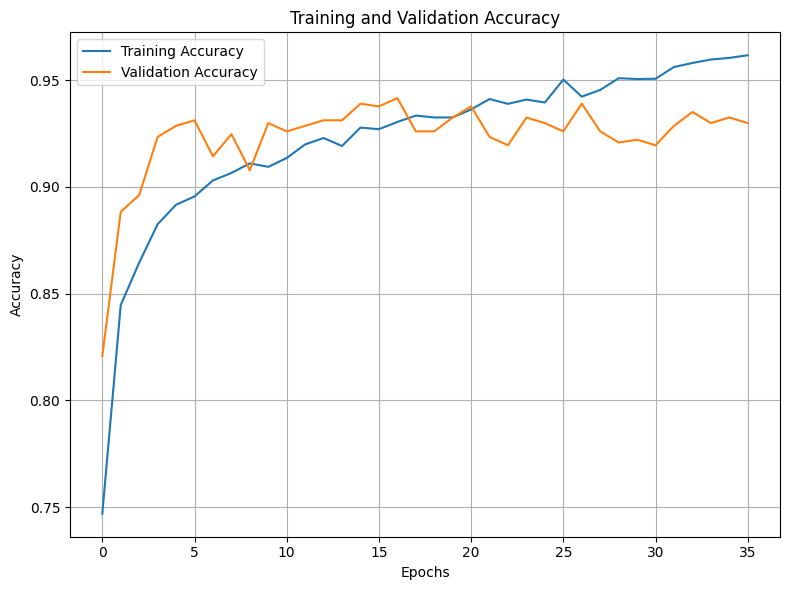

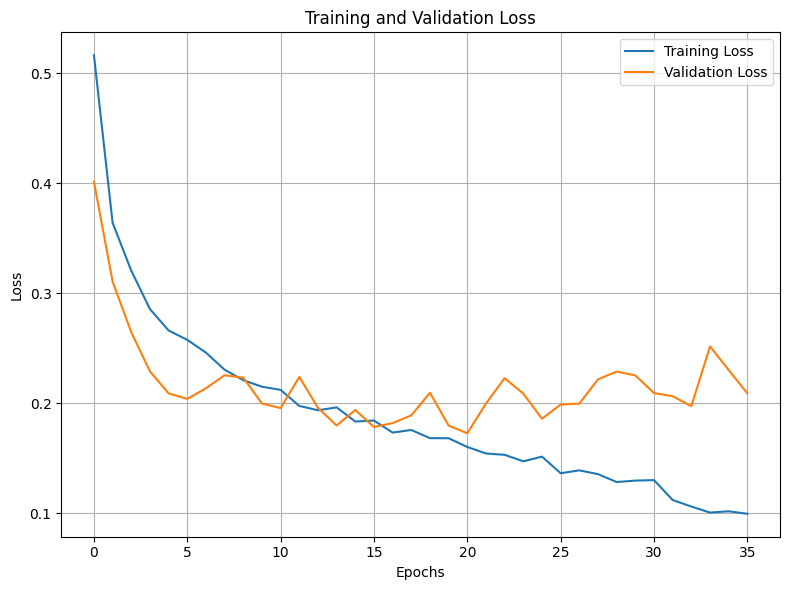

In [7]:
# Plot Accuracy (no markers)
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/tiamat_hd/ThesisWork/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9049 - loss: 0.2236
Test Loss: 0.2011, Test Accuracy: 0.9234
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


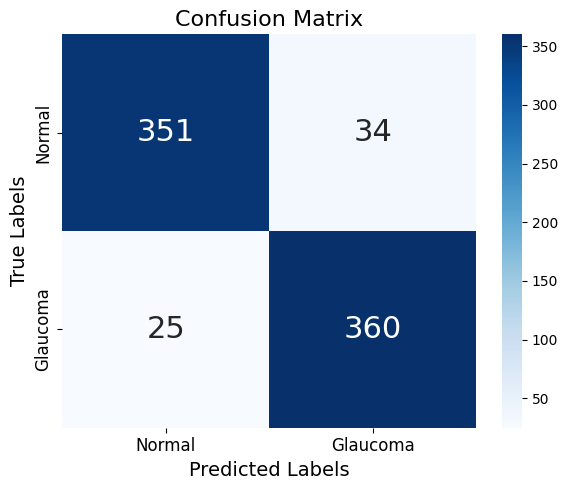

AUC Score: 0.9765


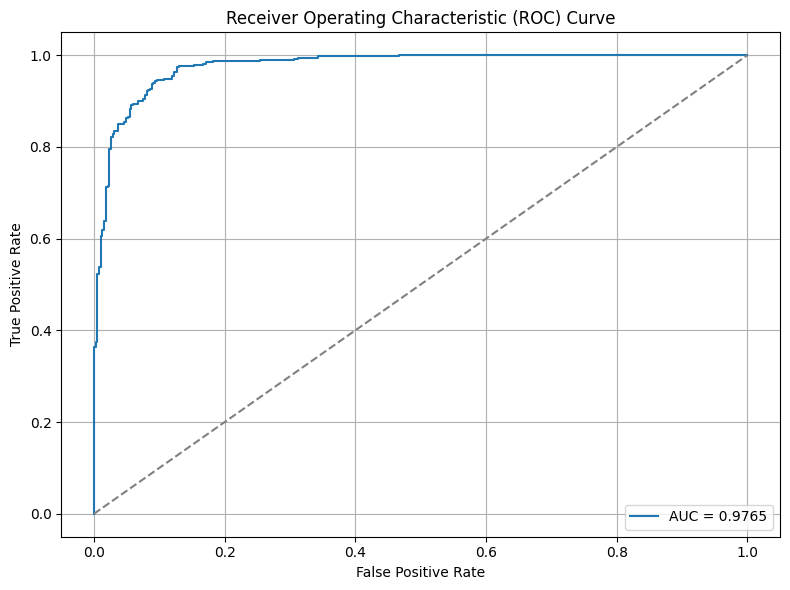

,precision,recall,f1-score,support
Normal,0.933511,0.911688,0.922470,385.000000
Glaucoma,0.913706,0.935065,0.924262,385.000000
accuracy,0.923377,0.923377,0.923377,0.923377
macro avg,0.923608,0.923377,0.923366,770.000000
weighted avg,0.923608,0.923377,0.923366,770.000000


In [8]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Model Evaluation
score = loaded_model.evaluate(test_batches, verbose=1)
print(f"Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

# Predictions
pred = loaded_model.predict(test_batches, verbose=1)
test_labels = test_batches.labels

# If sigmoid output
test_pred_labels = np.round(pred).astype(int).flatten()

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# Define class names
class_names = ['Normal', 'Glaucoma']

# Create the heatmap
plt.figure(figsize=(6, 5))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names,
           annot_kws={"size": 22})  # Large numbers in cells

# Set axis labels and title
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()

# AUC Score (needs predicted probabilities)
auc_score = roc_auc_score(test_labels, pred)
print(f"AUC Score: {auc_score:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, pred)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# Classification Report
test_report = classification_report(test_labels, test_pred_labels,
                                    target_names=['Normal', 'Glaucoma'],
                                    output_dict=True)
test_df = pd.DataFrame(test_report).transpose()
test_df



In [9]:
import tensorflow as tf
import numpy as np
import time

# Warm-up the model (important!)
_ = loaded_model.predict(next(iter(test_batches))[0], verbose=0)

# Create a test input (you can change shape if needed)
sample_input = np.random.rand(1, 224, 224, 3).astype(np.float32)

# Convert model to callable function for optimization
@tf.function
def run_inference(x):
    return model(x, training=False)

# Run several dry runs to warm up TensorFlow internals
for _ in range(10):
    _ = run_inference(sample_input)

# Time the inference using tf.profiler-like accuracy
repeats = 100
start = time.perf_counter()
for _ in range(repeats):
    _ = run_inference(sample_input)
end = time.perf_counter()

avg_time = (end - start) / repeats
print(f"🧪 Stable Average Inference Time per Image: {avg_time * 1000:.4f} ms")


2025-05-17 19:33:16.006195: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


🧪 Stable Average Inference Time per Image: 13.8650 ms


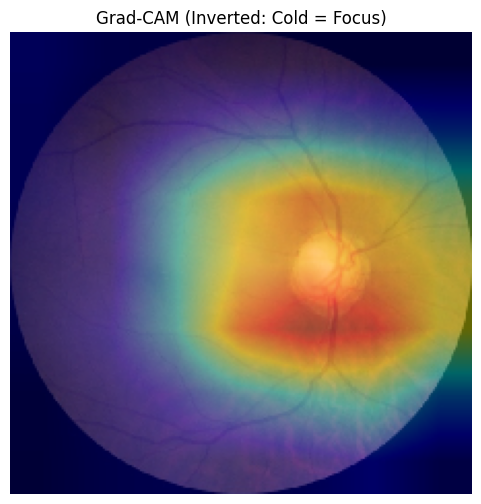

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Probability: 0.9952
Predicted Class: RG


2025-05-19 08:10:19.655271: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM Heatmap Generator (with inverted heatmap)
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    heatmap = 1.0 - heatmap  # Inverted: cold = focus
    return heatmap.numpy()

# Display Function with Inverted Heatmap
def display_gradcam(img_path, model, last_conv_layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)

    heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name)

    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_image = np.array(img).astype(np.uint8)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM (Inverted: Cold = Focus)")
    plt.show()


# Run Grad-CAM and Predict
img_path = r"./test/RG/EyePACS-TRAIN-RG-2898.jpg"  # Replace with your actual image path
last_conv_layer_name = 'Conv_1'          # Adjust based on your model architecture

# Run Grad-CAM using the correct model
display_gradcam(img_path, loaded_model, last_conv_layer_name)

# Predict using the correct model
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

pred_prob = loaded_model.predict(img_array)[0][0]
pred_class = int(pred_prob >= 0.5)

# Use actual class mapping from your test_batches
class_indices = test_batches.class_indices
reverse_class_indices = {v: k for k, v in class_indices.items()}

print(f"Predicted Probability: {pred_prob:.4f}")
print(f"Predicted Class: {reverse_class_indices[pred_class]}")
